Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix,classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50

# Set Path

In [29]:
train_dataset_path = '/kaggle/input/dogs-cats-images/dataset/training_set/'
test_dataset_path = '/kaggle/input/dogs-cats-images/dataset/test_set/'

# Image Resizing 

In [30]:
BATCH_SIZE = 32
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

print(f"Batch Size: {BATCH_SIZE}")
print(f"Image Shape: {IMG_SHAPE}")

Batch Size: 32
Image Shape: (256, 256, 3)


In [31]:
batch_size = 30
num_classes = 2
epochs = 30
input_shape = (150, 150, 3)

In [52]:
# train_datagen = ImageDataGenerator(rescale=1.0/255)
train_datagen = ImageDataGenerator(rescale=1.0/255,validation_split = 0.1)
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size = BATCH_SIZE,
                                                   class_mode = 'binary',
                                                   shuffle = True,
                                                   subset = 'training',
                                                   seed = 2)

Found 7200 images belonging to 2 classes.


In [53]:
validation_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                        target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                        batch_size = BATCH_SIZE,
                                                        class_mode = 'binary',
                                                        subset = 'validation',
                                                        shuffle = True,
                                                        seed = 2)

Found 800 images belonging to 2 classes.


In [54]:
test_datagen = ImageDataGenerator(rescale = 1.0/ 255)

test_generator = test_datagen.flow_from_directory(test_dataset_path,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'binary',
                                                 shuffle = False)

Found 2000 images belonging to 2 classes.


In [55]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")


Label Mappings for classes present in the training and validation datasets

0 : cats
1 : dogs


# View Sample Images

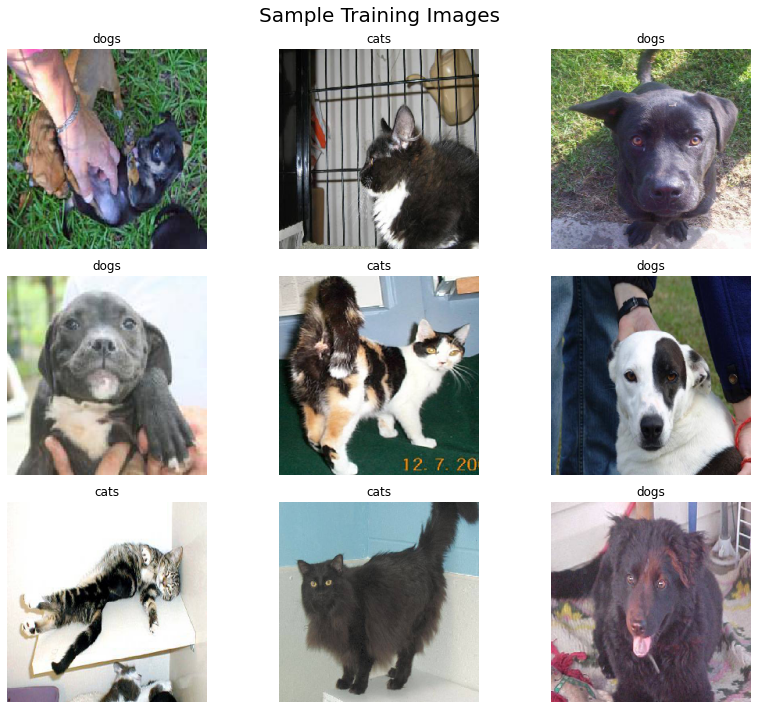

In [36]:
fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize = (12, 10))
idx = 0
plt.suptitle("Sample Training Images", fontsize = 20)
for i in range(3):
    for j in range(3):
        label = labels[train_generator[0][1][idx]]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.show()

# VGG16 model

In [56]:
base_model = VGG16(input_shape = IMG_SHAPE, include_top=False, weights='imagenet')

In [57]:
base_model.trainable = False

In [58]:
inputs = Input(shape = IMG_SHAPE)

x = base_model(inputs, training = False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs = inputs, outputs = outputs)

In [59]:
base_learning_rate = 0.001
optimizer = Adam(learning_rate=base_learning_rate)

In [60]:
model.compile(
    optimizer = optimizer,
    loss = BinaryCrossentropy(),
    metrics = ['accuracy']
)

In [61]:
initial_epochs = 10

history = model.fit(
    train_generator,
    steps_per_epoch=5,
    epochs=initial_epochs,
    validation_data=validation_generator,
    callbacks=[reduce_lr]
)

Epoch 1/10
5/5 [==============================] - 5s 1s/step - loss: 0.7526 - accuracy: 0.4625 - val_loss: 0.7081 - val_accuracy: 0.5175
Epoch 2/10
5/5 [==============================] - 4s 1s/step - loss: 0.7286 - accuracy: 0.5063 - val_loss: 0.6974 - val_accuracy: 0.5487
Epoch 3/10
5/5 [==============================] - 4s 1s/step - loss: 0.7885 - accuracy: 0.4437 - val_loss: 0.6886 - val_accuracy: 0.5238
Epoch 4/10
5/5 [==============================] - 4s 1s/step - loss: 0.6726 - accuracy: 0.5875 - val_loss: 0.6841 - val_accuracy: 0.5387
Epoch 5/10
5/5 [==============================] - 5s 1s/step - loss: 0.7266 - accuracy: 0.4938 - val_loss: 0.6805 - val_accuracy: 0.5425
Epoch 6/10
5/5 [==============================] - 4s 1s/step - loss: 0.7228 - accuracy: 0.5125 - val_loss: 0.6759 - val_accuracy: 0.5638
Epoch 7/10
5/5 [==============================] - 4s 1s/step - loss: 0.6689 - accuracy: 0.5688 - val_loss: 0.6715 - val_accuracy: 0.5800
Epoch 8/10
5/5 [=========================

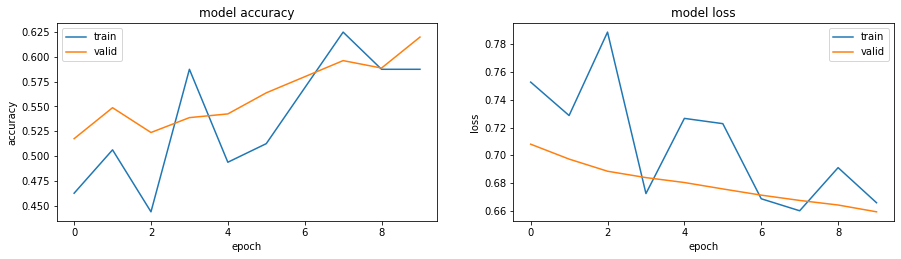

In [62]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

# CNN Architecture

In [63]:
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[256,256,3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [64]:
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [65]:
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16777344  
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [66]:
model = cnn.fit_generator(train_generator, steps_per_epoch=10, epochs=10,
                              validation_data= validation_generator, 
                              verbose=1) 

Epoch 1/10
10/10 [==============================] - 5s 497ms/step - loss: 2.2276 - accuracy: 0.5094 - val_loss: 0.6918 - val_accuracy: 0.4988
Epoch 2/10
10/10 [==============================] - 5s 480ms/step - loss: 0.6913 - accuracy: 0.5156 - val_loss: 0.6906 - val_accuracy: 0.5000
Epoch 3/10
10/10 [==============================] - 4s 462ms/step - loss: 0.6914 - accuracy: 0.4812 - val_loss: 0.6903 - val_accuracy: 0.5000
Epoch 4/10
10/10 [==============================] - 5s 520ms/step - loss: 0.6930 - accuracy: 0.4594 - val_loss: 0.6904 - val_accuracy: 0.5000
Epoch 5/10
10/10 [==============================] - 5s 484ms/step - loss: 0.6912 - accuracy: 0.5000 - val_loss: 0.6900 - val_accuracy: 0.5000
Epoch 6/10
10/10 [==============================] - 4s 459ms/step - loss: 0.6892 - accuracy: 0.5344 - val_loss: 0.6908 - val_accuracy: 0.5000
Epoch 7/10
10/10 [==============================] - 5s 483ms/step - loss: 0.6895 - accuracy: 0.5156 - val_loss: 0.6879 - val_accuracy: 0.5000
Epoch 

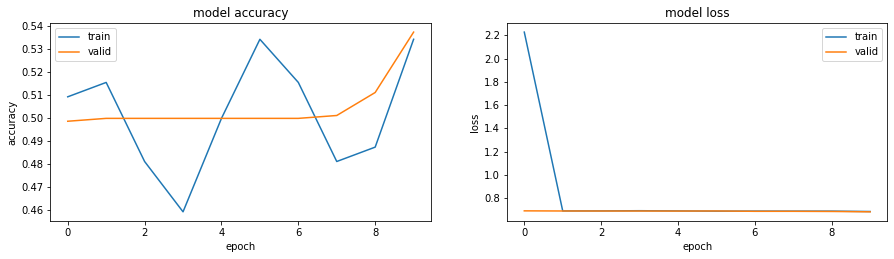

In [67]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(model.history['accuracy'])  
plt.plot(model.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(model.history['loss'])  
plt.plot(model.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()